In [1]:
import random
import matplotlib.pyplot as plt
import gradio as gr


from common import Item
from data_analys.data_generator import guillotine_cutting, guillotine_cutting_max, mass_generate
from ortools_models import task_two_model
from data_analys.draw_utils import draw_cutting, draw_cutting_mass

Running locally at: http://127.0.0.1:7861/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


presolving:
(round 1, fast)       40 del vars, 0 del conss, 0 add conss, 108 chg bounds, 0 chg sides, 12 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, exhaustive) 40 del vars, 1706 del conss, 0 add conss, 124 chg bounds, 0 chg sides, 14 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, fast)       40 del vars, 1706 del conss, 0 add conss, 124 chg bounds, 0 chg sides, 30 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 4, exhaustive) 40 del vars, 1706 del conss, 0 add conss, 124 chg bounds, 0 chg sides, 30 chg coeffs, 230 upgd conss, 0 impls, 0 clqs
   (0.1s) probing cycle finished: starting next cycle
(round 5, exhaustive) 40 del vars, 1706 del conss, 0 add conss, 204 chg bounds, 0 chg sides, 30 chg coeffs, 230 upgd conss, 897 impls, 0 clqs
(round 6, fast)       40 del vars, 1706 del conss, 0 add conss, 204 chg bounds, 40 chg sides, 110 chg coeffs, 230 upgd conss, 897 impls, 0 clqs
   (0.1s) probing: 33/800 (4.1%) - 0 fixings, 0 aggregations, 857 implications, 80 bound changes


KeyboardInterrupt: 

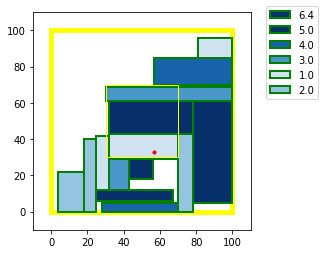

In [2]:
def demo_draw(W=100, H=100, num_rect=20, gen_type="max",
              min_side=5, random_seed=0,
              x_tol=20, y_tol=20, max_mass=5,
              time_limit_sec=120):
    
    if "max" == gen_type:
        items_xywh = guillotine_cutting_max(W, H, num_rect, min_side, random_seed)
    elif "rand1" == gen_type:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "", random_seed)
    else:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "equal", random_seed)

    items_xywh.sort(key=lambda i : i[2] * i[3], reverse=True)
    
    mass = mass_generate(items_xywh, W, H, x_tol, y_tol, 5)
    items_xywhm = [(x,y,w,h,m) for (x,y,w,h), m in zip(items_xywh, mass)]

    
    items_wh = [(w, h) if w > h else (h, w)
                for x, y, w, h in items_xywh
               ]
    items = [Item(w, h, m) for (w,h), m in zip(items_wh, mass)]

    _, space, _, positions = task_two_model(W, H, items, x_tol, y_tol, limit=int(time_limit_sec) * 1000)

    solve_xywhm = [(
                    pos.x,
                    pos.y,
                    it.width if not pos.rotated else it.height,
                    it.height if not pos.rotated else it.width,
                    it.mass
                    ) 
                  for it, pos in zip(items, positions) 
                  if pos is not None
                  ]
    
    fig_solve, ax = plt.subplots()
    draw_cutting_mass(W, H, solve_xywhm, x_tol, y_tol, ax=ax)
    
    fig_gen, ax = plt.subplots()
    draw_cutting_mass(W, H, items_xywhm, x_tol, y_tol, ax=ax)

    plt.close()

    return fig_solve, fig_gen


iface = gr.Interface(fn=demo_draw,
                     inputs=[
                             gr.inputs.Number(default=100, label="Pallet Width"),
                             gr.inputs.Number(default=100, label="Pallet Height"),
                             gr.inputs.Number(default=20, label="Number of rectangles"),
                             gr.inputs.Radio(["max", "rand", "equal"], default="equal", label="Generator type"),
                             gr.inputs.Number(default=5, label="Minimum side length"),
                             gr.inputs.Number(default=0, label="Random seed"),
                             gr.inputs.Number(default=20, label="Center X tolerance"),
                             gr.inputs.Number(default=20, label="Center Y tolerance"),
                             gr.inputs.Number(default=5, label="Max mass"),
                             gr.inputs.Number(default=120, label="Time limit, sec"),
                             ],
                     outputs=[
                         gr.outputs.Image(type="plot", label='Solver result'),
                         gr.outputs.Image(type="plot", label='Generated cutting'),
                     ],
                     live=False,
                     layout="unaligned",
                     title="Mass solver demo",
                     verbose=True
                     )

iface.launch(debug = True)